In [1]:
%matplotlib inline

import tkinter
import matplotlib
import platform
if platform.system() not in ['Linux', 'Darwin'] and not platform.system().startswith('CYGWIN'):
    matplotlib.use('TKAgg')
import matplotlib.pyplot as plt
from IPython import display
plt.rcParams.update({'font.size': 8})

# 活化函數大清點 (pytorch)

In [2]:
import gc
import glob
import os
import cv2
os.environ['TRIDENT_BACKEND'] = 'pytorch'
import trident as T
from trident import *
from trident.layers.pytorch_activations import __all__

Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: bgr.
Pytorch version:1.2.0+cu92.
Pillow version:6.2.1.
Using pillow image backend.


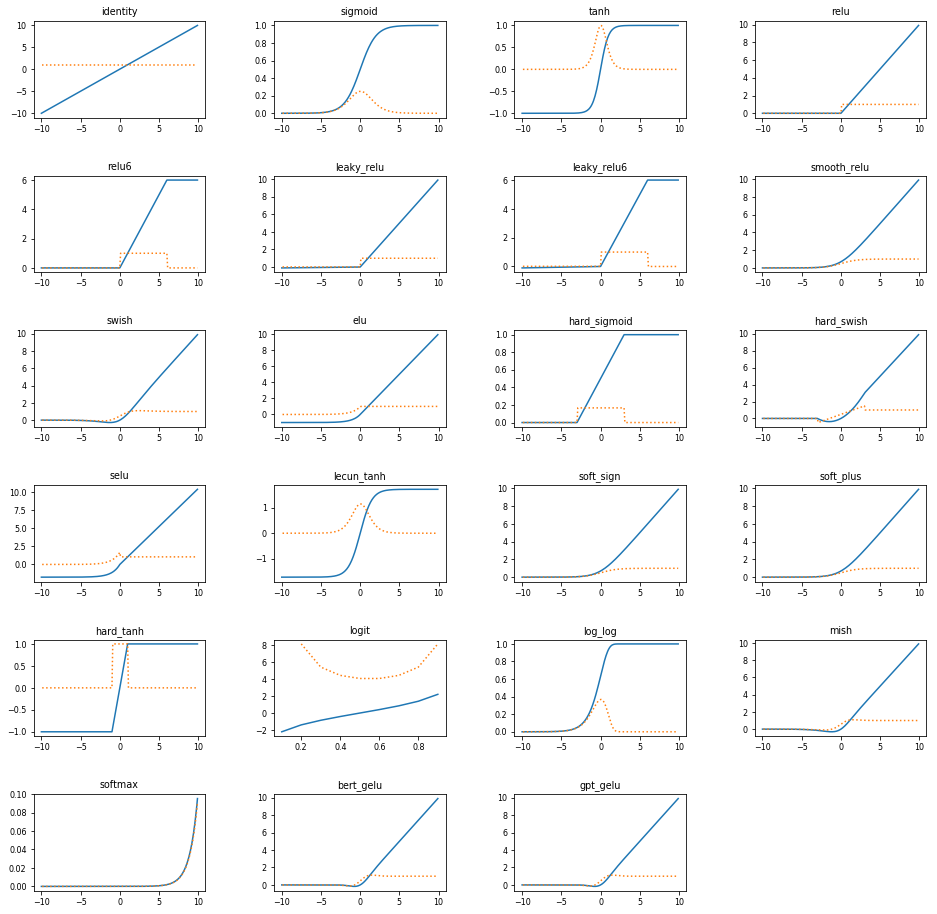

In [3]:
fig=plt.figure(figsize=(16,16))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
n=1
items= __all__[int( len(__all__)//2):-1]
plt.clf()
for k in  items :
    if k not in ('p_relu','prelu'):
        try:
            act_fn=get_activation(k)
            x =np.arange(-10, 10, 0.1).astype(np.float32)
            tensor_x=to_tensor(x)
            y=to_numpy(act_fn(tensor_x))
            ax1 = fig.add_subplot(6, 4, n)
            ax1.plot(x,y)
            ax1.plot(x[1:], np.diff(y) /(np.diff(x)+1e-8),ls=':')
            ax1.set_title(k)
            
        except Exception as e:
            print(e)
            pass
        n+=1
display.display(fig)

In [4]:
dataset=T.load_mnist('mnist','train',is_flatten=True)
dataset.image_transform_funcs=[normalize(127.5,127.5)]       


archive file is already existing, donnot need download again.
archive file is already existing, donnot need download again.
Mapping data  in train scenario  success, total 60000 record addeds.
Mapping label  in train scenario  success, total 60000 records added.
Mapping class_names  in en-US   success, total 10 class names added.


archive file is already existing, donnot need download again.
archive file is already existing, donnot need download again.
Mapping data  in train scenario  success, total 60000 record addeds.
Mapping label  in train scenario  success, total 60000 records added.
Mapping class_names  in en-US   success, total 10 class names added.
(64, 784)


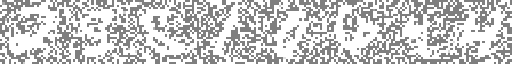

In [5]:
noise_dataset=T.load_mnist('mnist','train',is_flatten=True)
noise_dataset.image_transform_funcs=[normalize(127.5,127.5),add_noise(intensity=0.3)]       
noise_dataset.minibatch_size=64

im,label=noise_dataset.__next__()
print(im.shape)
im=array2image(np.concatenate(np.reshape(im[:8,:]*127.5+127.5,(8,28,28)).tolist(),1)).resize((64*8,64))
im

In [16]:
activations=['relu','sigmoid','tanh','selu','swish','mish']
def test_activity_function(act):
    #清掉記憶體垃圾以避免影響效能
    gc.collect()
    act_func=get_activation(act)
    print(act)
    
    #計算跑 10 萬次的總時間
    data =to_tensor(np.random.standard_normal((100000,1))) 
    start = time.time()
    results=[act_func(data[i]) for  i  in range(100000)]
    sec = time.time() - start
    print('{0:.6f} sec'.format(sec))

    #建 mnist模
    net=Sequential(
    Dense(64,use_bias=False,activation=act),
    Dense(10,use_bias=False,activation='softmax'))
    net.input_shape=[28*28]

    #為了避免 Adam自適應調整對測試的影響，這裡使用SGD 
    plan=TrainingPlan()\
    .add_training_item(
    TrainingItem(model=net,optimizer='SGD',lr=1e-3).with_loss(CrossEntropyLoss).with_metrics(accuracy))\
    .with_data_loader(dataset)\
    .within_minibatch_size(128)\
    .print_progress_scheduling(100,unit='batch')\

    #讓他跑1000 次，過程中的權重變化與梯度變化都保留
    plan.only_steps(num_steps=1000,keep_weights_history=True,keep_gradient_history=True,keep_target_history=False )
    #計算效度指標
    print('最低 loss {0:.4e}  最佳 metrics {1:.4%}  最後10次 metrics {2:.4%}'.format(min(plan.training_items[0].batch_loss_history['total_losses']),\
                                                                              max(plan.training_items[0].batch_metric_history['accuracy']) ,\
                                                                              np.array(plan.training_items[0].batch_metric_history['accuracy'][-10:]).mean()))

    # 分別使用乾淨數據與噪聲數據進行推論
    net.eval()
    accuracys=[]
    for i in range(100):
        input,target=dataset.__next__()
        input,target=to_tensor(input),to_tensor(target)
        accuracys.append(to_numpy(accuracy(net(input),target)))
    accuracys=np.asarray(accuracys)
        
    print('正常樣本 accuracy {0:.4%}  DIFF: {1:.4%} '.format(accuracys.mean(),accuracys.mean()-np.array(plan.training_items[0].batch_metric_history['accuracy'][-10:]).mean()))

    
    noise_accuracys=[]
    for i in range(100):
        input,target=noise_dataset.__next__()
        input,target=to_tensor(input),to_tensor(target)
        noise_accuracys.append(to_numpy(accuracy(net(input),target)))
    noise_accuracys=np.asarray(noise_accuracys)
        
    print('噪聲樣本 accuracy {0:.4%}  DIFF: {1:.4%} '.format(noise_accuracys.mean(),noise_accuracys.mean()-np.array(plan.training_items[0].batch_metric_history['accuracy'][-10:]).mean()))

    #繪製梯度與權重分布
    weights_history=plan.training_items[0].weights_history
    gradients_history=plan.training_items[0].gradients_history
    grads=[]
    weights=[]
    for i in range(len(gradients_history)):
        grads.append(gradients_history[i]['0.weight'].reshape([-1]))

    for i in range(len(weights_history)):
         weights.append(weights_history[i]['0.weight'].reshape([-1]))
    print(grads[:3])
    grads=np.asarray(grads)
    weights=np.asarray(weights)
    #計算梯度為零比例
    print('梯度為零比例 : {0:.3%}'.format(np.equal(grads,0).astype(np.float32).mean()))

    steps_histogram(grads,weights,inteval=50,imshow=True)
    

relu
8.118285 sec
  Step: 3m7s     | Tot: 0ms      | Loss: 2.361   | Accuracy: 10.156%  | learning rate: 1.0000e-03| epoch: 1 ( 0/1000 )
  Step: 487ms    | Tot: 487ms    | Loss: 2.288   | Accuracy: 17.188%  | learning rate: 1.0000e-03| epoch: 1 ( 100/1000 )
  Step: 552ms    | Tot: 1s40ms   | Loss: 2.246   | Accuracy: 21.094%  | learning rate: 1.0000e-03| epoch: 1 ( 200/1000 )
  Step: 583ms    | Tot: 1s623ms  | Loss: 2.211   | Accuracy: 25.000%  | learning rate: 1.0000e-03| epoch: 1 ( 300/1000 )
  Step: 491ms    | Tot: 2s115ms  | Loss: 2.172   | Accuracy: 28.906%  | learning rate: 1.0000e-03| epoch: 1 ( 400/1000 )
  Step: 528ms    | Tot: 2s643ms  | Loss: 2.069   | Accuracy: 39.062%  | learning rate: 1.0000e-03| epoch: 1 ( 500/1000 )
  Step: 506ms    | Tot: 3s150ms  | Loss: 2.015   | Accuracy: 44.531%  | learning rate: 1.0000e-03| epoch: 1 ( 600/1000 )
  Step: 480ms    | Tot: 3s631ms  | Loss: 2.121   | Accuracy: 33.594%  | learning rate: 1.0000e-03| epoch: 1 ( 700/1000 )
  Step: 536ms   

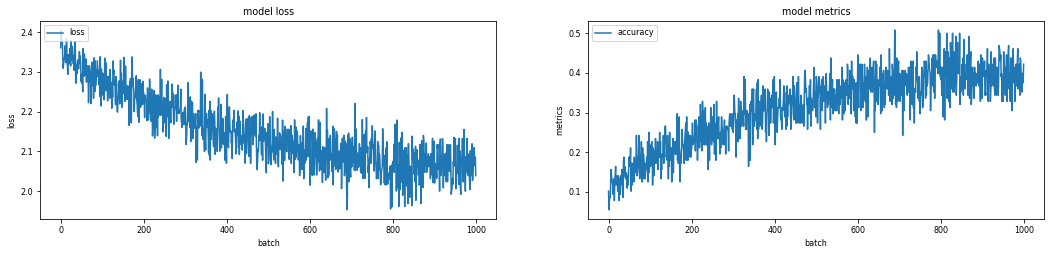

最低 loss 1.9527e+00  最佳 metrics 50.7812%  最後10次 metrics 39.4531%
正常樣本 accuracy 39.4531%  DIFF: 0.0000% 
噪聲樣本 accuracy 35.2344%  DIFF: -4.2188% 
[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)]
梯度為零比例 : 42.496%


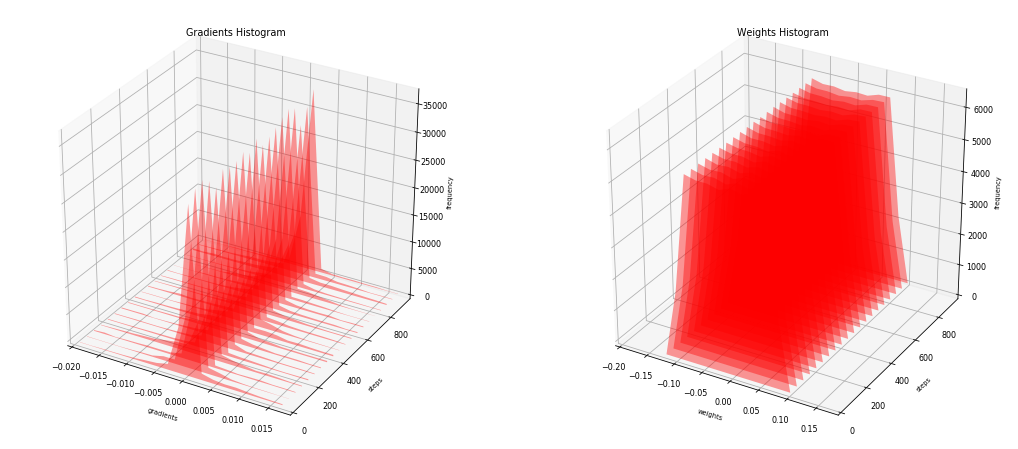

In [17]:
test_activity_function('relu')

leaky_relu
5.482328 sec
  Step: 8s791ms  | Tot: 0ms      | Loss: 2.359   | Accuracy: 10.156%  | learning rate: 1.0000e-03| epoch: 1 ( 0/1000 )
  Step: 533ms    | Tot: 533ms    | Loss: 2.297   | Accuracy: 16.406%  | learning rate: 1.0000e-03| epoch: 1 ( 100/1000 )
  Step: 507ms    | Tot: 1s41ms   | Loss: 2.249   | Accuracy: 21.094%  | learning rate: 1.0000e-03| epoch: 1 ( 200/1000 )
  Step: 486ms    | Tot: 1s527ms  | Loss: 2.233   | Accuracy: 22.656%  | learning rate: 1.0000e-03| epoch: 1 ( 300/1000 )
  Step: 474ms    | Tot: 2s2ms    | Loss: 2.102   | Accuracy: 35.156%  | learning rate: 1.0000e-03| epoch: 1 ( 400/1000 )
  Step: 501ms    | Tot: 2s504ms  | Loss: 2.092   | Accuracy: 36.719%  | learning rate: 1.0000e-03| epoch: 1 ( 500/1000 )
  Step: 517ms    | Tot: 3s21ms   | Loss: 2.084   | Accuracy: 37.500%  | learning rate: 1.0000e-03| epoch: 1 ( 600/1000 )
  Step: 510ms    | Tot: 3s532ms  | Loss: 2.074   | Accuracy: 38.281%  | learning rate: 1.0000e-03| epoch: 1 ( 700/1000 )
  Step: 50

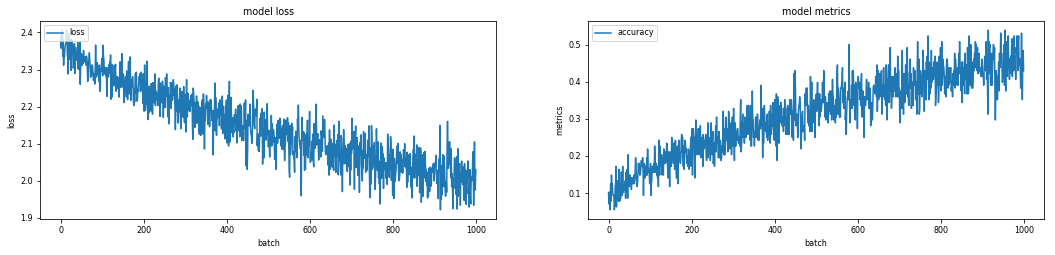

最低 loss 1.9218e+00  最佳 metrics 53.9062%  最後10次 metrics 43.5156%
正常樣本 accuracy 46.8437%  DIFF: 3.3281% 
噪聲樣本 accuracy 38.4375%  DIFF: -5.0781% 
梯度為零比例 : 34.820%


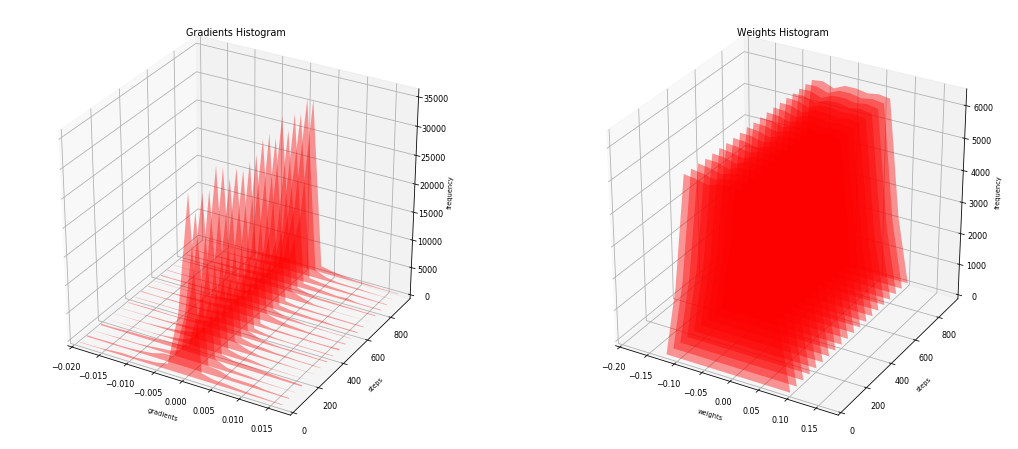

In [8]:
test_activity_function('leaky_relu')

sigmoid
6.024094 sec
  Step: 8s877ms  | Tot: 0ms      | Loss: 2.303   | Accuracy: 13.281%  | learning rate: 1.0000e-03| epoch: 1 ( 0/1000 )
  Step: 504ms    | Tot: 504ms    | Loss: 2.293   | Accuracy: 13.281%  | learning rate: 1.0000e-03| epoch: 1 ( 100/1000 )
  Step: 492ms    | Tot: 997ms    | Loss: 2.281   | Accuracy: 19.531%  | learning rate: 1.0000e-03| epoch: 1 ( 200/1000 )
  Step: 493ms    | Tot: 1s491ms  | Loss: 2.272   | Accuracy: 19.531%  | learning rate: 1.0000e-03| epoch: 1 ( 300/1000 )
  Step: 489ms    | Tot: 1s980ms  | Loss: 2.273   | Accuracy: 18.750%  | learning rate: 1.0000e-03| epoch: 1 ( 400/1000 )
  Step: 491ms    | Tot: 2s472ms  | Loss: 2.250   | Accuracy: 26.562%  | learning rate: 1.0000e-03| epoch: 1 ( 500/1000 )
  Step: 491ms    | Tot: 2s964ms  | Loss: 2.284   | Accuracy: 17.188%  | learning rate: 1.0000e-03| epoch: 1 ( 600/1000 )
  Step: 476ms    | Tot: 3s440ms  | Loss: 2.264   | Accuracy: 21.094%  | learning rate: 1.0000e-03| epoch: 1 ( 700/1000 )
  Step: 478ms

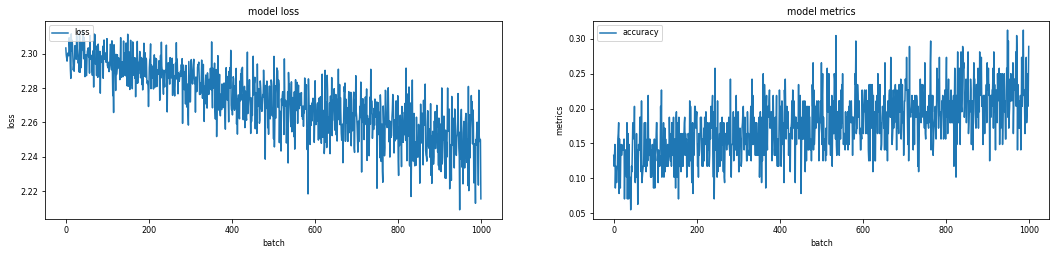

最低 loss 2.2092e+00  最佳 metrics 31.2500%  最後10次 metrics 22.2656%
正常樣本 accuracy 21.9688%  DIFF: -0.2969% 
噪聲樣本 accuracy 20.1406%  DIFF: -2.1250% 
梯度為零比例 : 41.417%


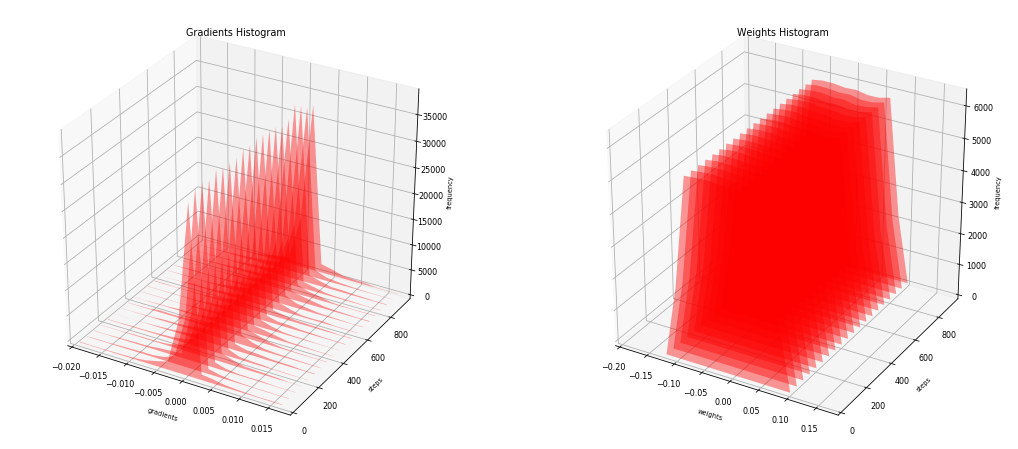

In [9]:
test_activity_function('sigmoid')

tanh
6.160520 sec
  Step: 9s48ms   | Tot: 0ms      | Loss: 2.306   | Accuracy: 11.719%  | learning rate: 1.0000e-03| epoch: 1 ( 0/1000 )
  Step: 496ms    | Tot: 496ms    | Loss: 2.302   | Accuracy: 12.500%  | learning rate: 1.0000e-03| epoch: 1 ( 100/1000 )
  Step: 505ms    | Tot: 1s2ms    | Loss: 2.276   | Accuracy: 16.406%  | learning rate: 1.0000e-03| epoch: 1 ( 200/1000 )
  Step: 489ms    | Tot: 1s492ms  | Loss: 2.287   | Accuracy: 15.625%  | learning rate: 1.0000e-03| epoch: 1 ( 300/1000 )
  Step: 492ms    | Tot: 1s984ms  | Loss: 2.237   | Accuracy: 25.000%  | learning rate: 1.0000e-03| epoch: 1 ( 400/1000 )
  Step: 493ms    | Tot: 2s478ms  | Loss: 2.202   | Accuracy: 31.250%  | learning rate: 1.0000e-03| epoch: 1 ( 500/1000 )
  Step: 495ms    | Tot: 2s974ms  | Loss: 2.178   | Accuracy: 39.062%  | learning rate: 1.0000e-03| epoch: 1 ( 600/1000 )
  Step: 489ms    | Tot: 3s463ms  | Loss: 2.137   | Accuracy: 36.719%  | learning rate: 1.0000e-03| epoch: 1 ( 700/1000 )
  Step: 494ms   

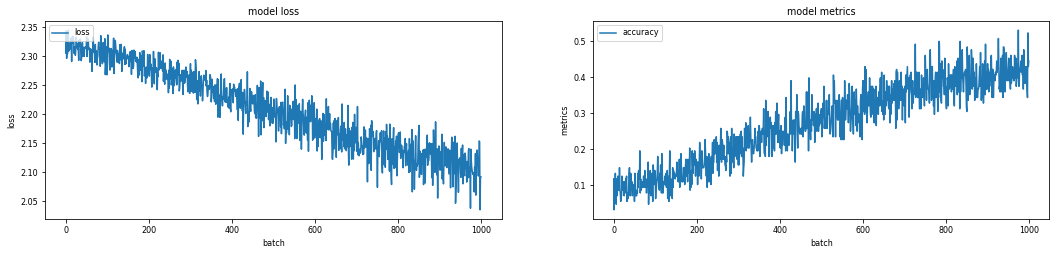

最低 loss 2.0355e+00  最佳 metrics 53.1250%  最後10次 metrics 41.7188%
正常樣本 accuracy 42.2031%  DIFF: 0.4844% 
噪聲樣本 accuracy 33.8594%  DIFF: -7.8594% 
梯度為零比例 : 57.533%


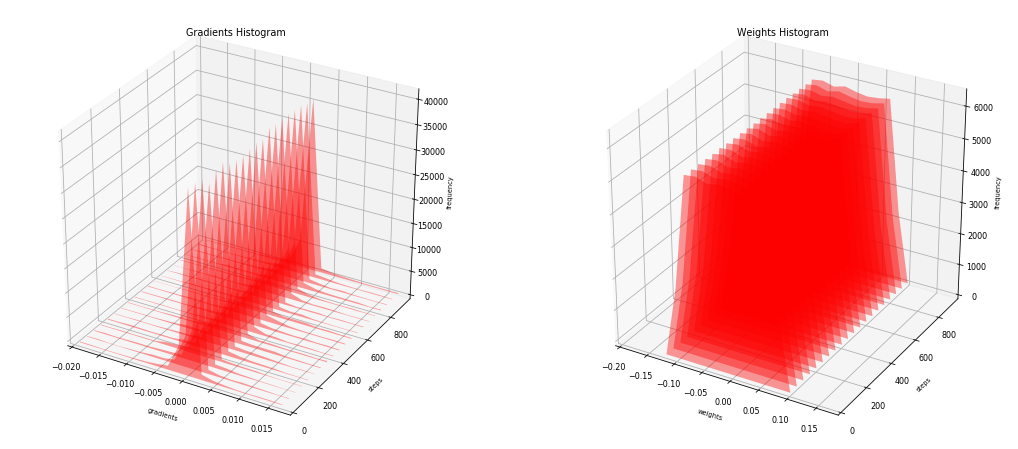

In [10]:
test_activity_function('tanh')

selu
5.936119 sec
  Step: 8s774ms  | Tot: 0ms      | Loss: 2.355   | Accuracy: 10.156%  | learning rate: 1.0000e-03| epoch: 1 ( 0/1000 )
  Step: 541ms    | Tot: 541ms    | Loss: 2.315   | Accuracy: 14.844%  | learning rate: 1.0000e-03| epoch: 1 ( 100/1000 )
  Step: 490ms    | Tot: 1s32ms   | Loss: 2.281   | Accuracy: 17.969%  | learning rate: 1.0000e-03| epoch: 1 ( 200/1000 )
  Step: 494ms    | Tot: 1s526ms  | Loss: 2.277   | Accuracy: 17.969%  | learning rate: 1.0000e-03| epoch: 1 ( 300/1000 )
  Step: 491ms    | Tot: 2s18ms   | Loss: 2.233   | Accuracy: 22.656%  | learning rate: 1.0000e-03| epoch: 1 ( 400/1000 )
  Step: 503ms    | Tot: 2s522ms  | Loss: 2.188   | Accuracy: 27.344%  | learning rate: 1.0000e-03| epoch: 1 ( 500/1000 )
  Step: 481ms    | Tot: 3s3ms    | Loss: 2.245   | Accuracy: 21.875%  | learning rate: 1.0000e-03| epoch: 1 ( 600/1000 )
  Step: 480ms    | Tot: 3s484ms  | Loss: 2.195   | Accuracy: 26.562%  | learning rate: 1.0000e-03| epoch: 1 ( 700/1000 )
  Step: 503ms   

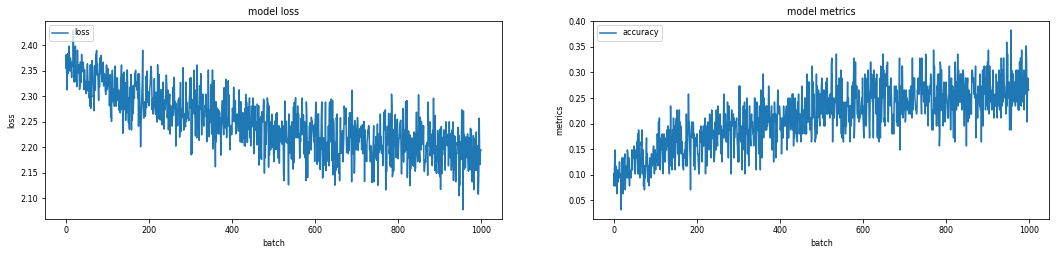

最低 loss 2.0778e+00  最佳 metrics 38.2812%  最後10次 metrics 28.2031%
正常樣本 accuracy 26.8047%  DIFF: -1.3984% 
噪聲樣本 accuracy 22.5313%  DIFF: -5.6719% 
梯度為零比例 : 41.918%


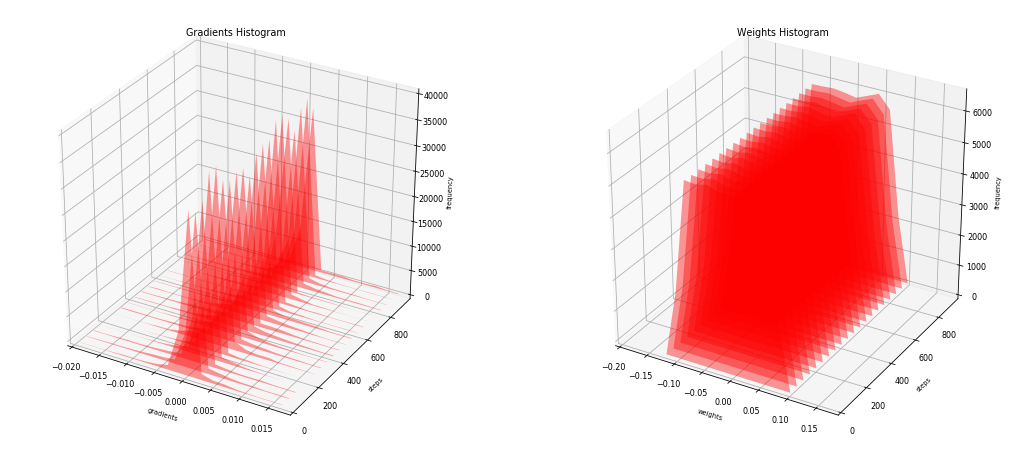

In [11]:
test_activity_function('selu')

swish
11.041267 sec
  Step: 14s366ms | Tot: 0ms      | Loss: 2.367   | Accuracy: 9.375%   | learning rate: 1.0000e-03| epoch: 1 ( 0/1000 )
  Step: 536ms    | Tot: 536ms    | Loss: 2.216   | Accuracy: 24.219%  | learning rate: 1.0000e-03| epoch: 1 ( 100/1000 )
  Step: 527ms    | Tot: 1s64ms   | Loss: 2.119   | Accuracy: 33.594%  | learning rate: 1.0000e-03| epoch: 1 ( 200/1000 )
  Step: 513ms    | Tot: 1s577ms  | Loss: 2.141   | Accuracy: 32.031%  | learning rate: 1.0000e-03| epoch: 1 ( 300/1000 )
  Step: 515ms    | Tot: 2s93ms   | Loss: 2.074   | Accuracy: 38.281%  | learning rate: 1.0000e-03| epoch: 1 ( 400/1000 )
  Step: 500ms    | Tot: 2s594ms  | Loss: 2.007   | Accuracy: 45.312%  | learning rate: 1.0000e-03| epoch: 1 ( 500/1000 )
  Step: 510ms    | Tot: 3s104ms  | Loss: 2.015   | Accuracy: 44.531%  | learning rate: 1.0000e-03| epoch: 1 ( 600/1000 )
  Step: 512ms    | Tot: 3s617ms  | Loss: 1.914   | Accuracy: 54.688%  | learning rate: 1.0000e-03| epoch: 1 ( 700/1000 )
  Step: 516ms 

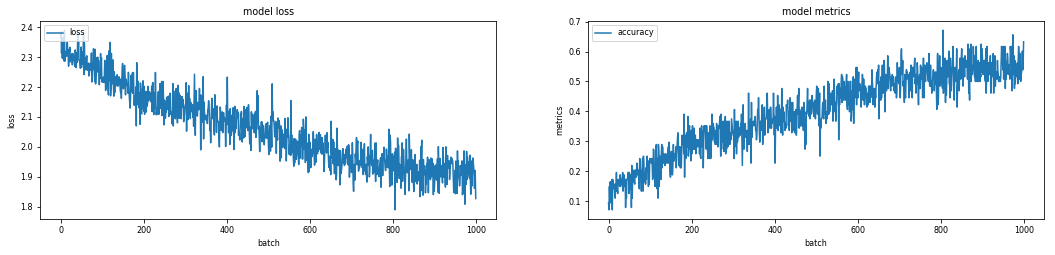

最低 loss 1.7894e+00  最佳 metrics 67.1875%  最後10次 metrics 55.7813%
正常樣本 accuracy 55.6484%  DIFF: -0.1328% 
噪聲樣本 accuracy 43.4375%  DIFF: -12.3438% 
梯度為零比例 : 38.632%


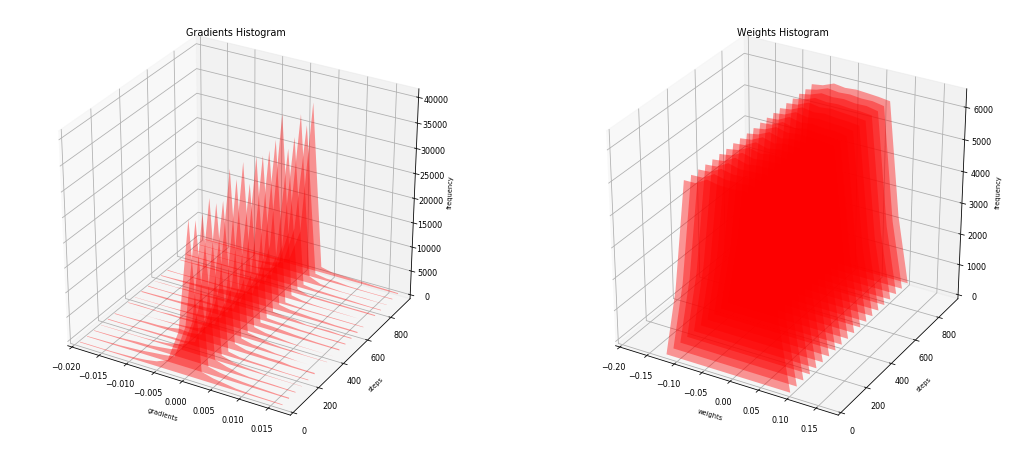

In [12]:
test_activity_function('swish')

mish
19.306735 sec
  Step: 22s257ms | Tot: 0ms      | Loss: 2.413   | Accuracy: 4.688%   | learning rate: 1.0000e-03| epoch: 1 ( 0/1000 )
  Step: 695ms    | Tot: 695ms    | Loss: 2.352   | Accuracy: 10.938%  | learning rate: 1.0000e-03| epoch: 1 ( 100/1000 )
  Step: 629ms    | Tot: 1s324ms  | Loss: 2.430   | Accuracy: 3.125%   | learning rate: 1.0000e-03| epoch: 1 ( 200/1000 )
  Step: 566ms    | Tot: 1s890ms  | Loss: 2.334   | Accuracy: 12.500%  | learning rate: 1.0000e-03| epoch: 1 ( 300/1000 )
  Step: 552ms    | Tot: 2s443ms  | Loss: 2.273   | Accuracy: 18.750%  | learning rate: 1.0000e-03| epoch: 1 ( 400/1000 )
  Step: 550ms    | Tot: 2s994ms  | Loss: 2.189   | Accuracy: 27.344%  | learning rate: 1.0000e-03| epoch: 1 ( 500/1000 )
  Step: 547ms    | Tot: 3s541ms  | Loss: 2.204   | Accuracy: 25.781%  | learning rate: 1.0000e-03| epoch: 1 ( 600/1000 )
  Step: 542ms    | Tot: 4s84ms   | Loss: 2.113   | Accuracy: 34.375%  | learning rate: 1.0000e-03| epoch: 1 ( 700/1000 )
  Step: 546ms  

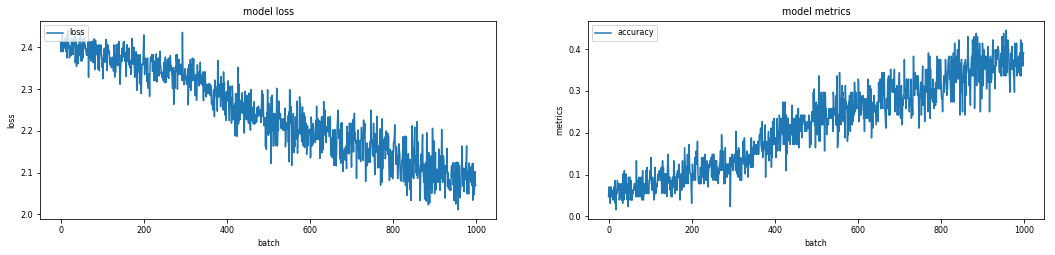

最低 loss 2.0110e+00  最佳 metrics 44.5312%  最後10次 metrics 38.2031%
正常樣本 accuracy 38.7969%  DIFF: 0.5937% 
噪聲樣本 accuracy 30.2500%  DIFF: -7.9531% 
梯度為零比例 : 37.723%


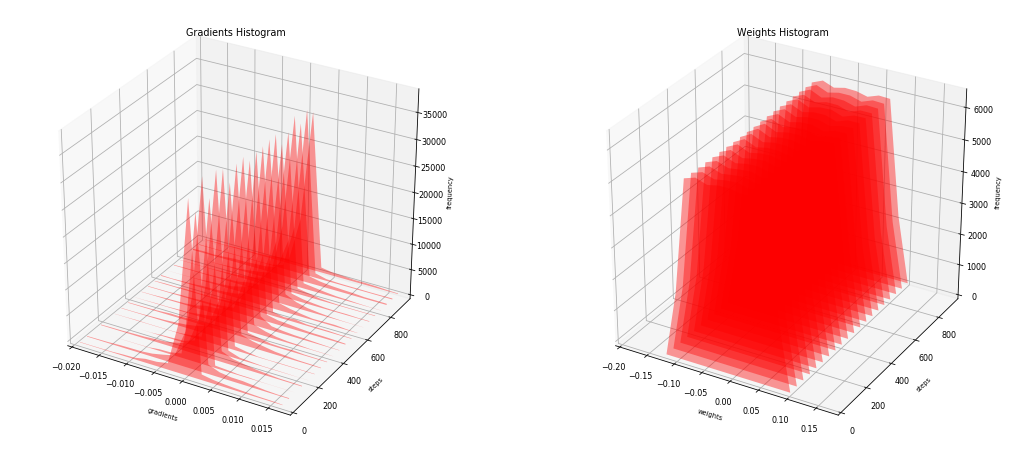

In [13]:
test_activity_function('mish')